# Cleaning and Exploring Mountain Project Climbing Data
[Mountain Project](http://mountainproject.com/) is an online climbing guidebook for hundreds of thousands of routes all around the world.
One of its cool features is a route finder that will create a table of routes based on certain parameters you give it,
such as location and difficulty.
You can then export this table as a `.csv` file.
So I used this feature to download information about every roped climb in the Red River Gorge and New River Gorge,
since these are the two major climbing destinations nearest to where I live, and they are places where I have actually climbed before.

The main focus of this notebook is demonstrating some basic data cleaning with Pandas.
But at the end I'll do a little exploratory analysis as a payoff for all that hard cleaning work.
Another added bonus is that I demonstrate some quick and easy (but primitive) web scraping 
for gathering some data that the route finder doesn't export.

Let's see if there's anything interesting we can learn about the climbing at the Red and the New!

First of all, we have the standard imports for working with data in Python.
In case you don't know, `%matplotlib inline` allows plots to appear directly in the notebook,
and `sns.set()` sets the default plot style to Seaborn's dark grey grid style.

In [1]:
# standard imports for working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# suppress some annoying deprecation warnings from seaborn
import warnings
warnings.filterwarnings("ignore")
# in-line plots
%matplotlib inline
# default seaborn style
sns.set()

Now for loading the data.
The route finder will only let you download 1000 routes at a time, so I had to split the routes across five files.
(Four files would have worked in principle, but it's hard to get exactly 1000 routes with each query.)
To keep myself organized, I used a few levels of folders when storing the data.
This has the drawback that it can be annoying to type out all the paths for the files I want to read in.
Don't worry though!
IPython has the excellent feature of letting you use shell commands right inside notebooks;
you just need to preface the command with an exclamation point.
You can even assign the result to a variable and get back a special list type that you can grep.
Below, I use `!find` and the `.grep` method to pick out the paths of the files I want to open;
then I use a generator expression with `pd.read_csv` and `pd.concat` to load up all the files into one big dataframe.
Finally, I check the shape, which should tell us that there are 3275 rows.

In [2]:
paths = !find .
csvs = paths.grep(r'[nr]rg\d\.csv')
dfs = (pd.read_csv(file) for file in csvs)
df = pd.concat(dfs, ignore_index=True)
df.shape

(3275, 11)

Okay now that we've loaded up the data, let's check it out with a call to `head`.
We've got 11 variables:
- `Route` is the name of the route, obviously.
- `Location` is an untidy column that contains multiple levels of location information.
We'll probably have to wrangle that into a more manageable form to make best use of it.
- `URL` is a link to the route's page on Mountain Project.
- `Avg Stars` is the average rating users gave to a route, where each user can rate a route 0, 1, 2, 3, or 4 stars,
depending on how much they liked it.
- `Your Stars` is my ratings for the routes. Every value is -1, which indicates a missing value, since I haven't rated any routes.
- `Route Type` describes the climbing style of the route, usually either sport (bolted protection) or trad (place your own protection).
- `Rating` is the difficulty of the route in the [Yosemite Decimal System](https://en.wikipedia.org/wiki/Yosemite_Decimal_System).
- `Pitches` is the number of pitches in a climb. A pitch is a section of climbing between stops at a belay station.
One reason a route may be split into multiple pitches is that the rope is too short to do the whole route in one pitch,
or the climber doesn't have enough gear to protect the whole route at once.
- `Length` is the total length of the climb in feet.
- `Area Latitude` and `Area Longitude` are the latitude and longitude of the route.



In [99]:
df.head()

,Route,Location,URL,Avg Stars,Your Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude
0,Aimee's Jugs,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10739338...,2.7,-1,Sport,5.6,1,70.0,38.2338,-80.8552
1,Jay's Corner,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10841368...,1.5,-1,Trad,5.6,1,70.0,38.2338,-80.8552
2,Bongo,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10738408...,2.7,-1,Sport,5.7,1,70.0,38.2338,-80.8552
3,East Meck Shoot Out,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/11374563...,2.0,-1,Trad,5.7,1,50.0,38.2338,-80.8552
4,Unnamed crack,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10840088...,2.0,-1,Trad,5.7,1,50.0,38.2338,-80.8552


The first step we'll take toward tidying the data is removing the `Your Stars` column, since it serves no purpose.

In [100]:
df = df.drop(columns='Your Stars')

On the other hand, the `Avg Stars` columns seems to be among to most important, since it provides some measure of the quality of the climb.
For example, it could be very intersting to discover which areas have the best climbs.
But there's a problem. We only have an average, and we have no idea how many people contributed to that average.
An average rating of 4.0 (highest possible) is impressive if 50 people agree, but not so impressive if it's just one person's opinion.
The number of votes that went into each average is actually reported on the route's page,
so we can do some rudimentary web scraping to get that crucial information.

Let's use the URLs to scrape the number of votes that went into each rating.
We'll just use `urllib` from the Python standard library to get the raw text of the page.
Then we'll use a regular expression to find and extract the vote count.
We'll also use a 3-second delay to be extra polite to Mountain Project,
since I'm not sure what their policy on this is, and I really don't want to be banned.
This took a few hours, so I added a progress indicator.
In case, you've never seen it before, a neat little trick is adding the carriage return `\r` to the start of the string you print,
and then use the keyword argument `end=''` to make sure `print` doesn't append a newline.
Then you can keep writing over top of the same line.

In [5]:
import re
import time
from urllib.request import urlopen

# compile the regular expression since we'll be using it repeatedly
rx = re.compile(r'Avg: [\d\.]* from (\d+)')
votes = []
urls = df.URL # I had other urls here when testing this, that's why there's a separate variable
for i, url in enumerate(urls):
    print(f'\r{i / len(urls) * 100:.2f}%', end='')
    with urlopen(url) as f:
        content = str(f.read())
    votes.append(int(rx.search(content).group(1)))
    time.sleep(3)

99.97%

Okay, now we've got the vote counts, so let's add that to the data frame and save it,
before we somehow lose our precious web-scraped info.

In [101]:
df['votes'] = votes
df.to_csv('data/full-data.csv', index=False)

Now we re-load the data frame, so we can start from here without re-running that long web scraping loop.

In [2]:
df = pd.read_csv('data/full-data.csv')
df.head()

,Route,Location,URL,Avg Stars,Route Type,Rating,Pitches,Length,Area Latitude,Area Longitude,votes
0,Aimee's Jugs,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10739338...,2.7,Sport,5.6,1,70.0,38.2338,-80.8552,72
1,Jay's Corner,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10841368...,1.5,Trad,5.6,1,70.0,38.2338,-80.8552,4
2,Bongo,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10738408...,2.7,Sport,5.7,1,70.0,38.2338,-80.8552,90
3,East Meck Shoot Out,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/11374563...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,1
4,Unnamed crack,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10840088...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,11


Now that we've finished gathering the data, we can proceed with the clean up.

The next thing I'm going to do is change the column names.
Most of the columns I've just changed slightly to be one word and lowercase.
The more notable changes are that `Route` becomes `name`, `Avg Stars` becomes `rating`, and `Rating` becomes `grade`.
This is because I think 'grade' is the more common term for the route difficulty, and I think of the 'Avg Stars' as being more of a 'rating'.
Hopefullly this isn't too confusing.
I also set the route name to be the index.

In [3]:
name_mapping = {
    'Route': 'name',
    'Location': 'location',
    'URL': 'url',
    'Avg Stars': 'rating',
    'Route Type': 'type',
    'Rating': 'grade',
    'Pitches': 'pitches',
    'Length': 'length',
    'Area Latitude': 'latitude',
    'Area Longitude': 'longitude',
    'votes': 'votes'
}
df = df.rename(name_mapping, axis='columns')
df = df.set_index('name')
df.head()

,location,url,rating,type,grade,pitches,length,latitude,longitude,votes
name,,,,,,,,,,
Aimee's Jugs,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10739338...,2.7,Sport,5.6,1,70.0,38.2338,-80.8552,72
Jay's Corner,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10841368...,1.5,Trad,5.6,1,70.0,38.2338,-80.8552,4
Bongo,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10738408...,2.7,Sport,5.7,1,70.0,38.2338,-80.8552,90
East Meck Shoot Out,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/11374563...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,1
Unnamed crack,Whippoorwill > Summersville and Gauley River >...,https://www.mountainproject.com/route/10840088...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,11


Next, let's work on the two messy columns: `location` and `grade`.
`location` is messy because it contains multiple pieces of information stuck together as a string.
See below for an example. There are 4 levels of location information.

In [4]:
df.location[1]

'Whippoorwill > Summersville and Gauley River > The New River Gorge > West Virginia'

So let's split on ` > `. But we should check how many levels of location information there are.
Is it always 4?

In [5]:
df.location.str.split(' > ').apply(len).value_counts().sort_index()

3     549
4    1502
5    1224
Name: location, dtype: int64

Aha, so the number of levels varies from 3 to 5. 
Now, if we pass the `expand=True` option to `str.split` we'll get a dataframe back with 5 columns, two of which will be sometimes missing.
But the problem is that we really need to reverse the lists before splitting them into columns.
This is because the location identifier always has the state, for example, but the state appears last.
So when there are all 5 levels of detail, the state is in the fifth column.
But when there are only 4 levels of detail, the state is in the fourth column.
We want one of the columns to always be the 'state' column though.
At least, that's what makes sense to me.
I don't think Pandas has any nice built-in way to do this, so we'll just resort to `apply`.

The following `lambda` function takes a location string, splits it on ` > `, reverses the resulting list, then casts it to the `Series` type
to make a dataframe with multiple columns rather than a series with list values.

In [6]:
location_df = df.location.apply(lambda x: pd.Series(x.split(' > ')[::-1]))
location_df.head()

,0,1,2,3,4
name,,,,,
Aimee's Jugs,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
Jay's Corner,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
Bongo,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
East Meck Shoot Out,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
Unnamed crack,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN


Now we need to add these columns to our dataframe, and remove the old location column.
I do this below, choosing some rather arbitrary names for the different location levels (other than state).

In [7]:
df = df.drop(columns='location')
df['state'] = location_df[0]
df['gorge'] = location_df[1]
df['area'] = location_df[2]
df['crag'] = location_df[3]
df['subcrag'] = location_df[4]
df.head()

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag
name,,,,,,,,,,,,,,
Aimee's Jugs,https://www.mountainproject.com/route/10739338...,2.7,Sport,5.6,1,70.0,38.2338,-80.8552,72,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
Jay's Corner,https://www.mountainproject.com/route/10841368...,1.5,Trad,5.6,1,70.0,38.2338,-80.8552,4,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
Bongo,https://www.mountainproject.com/route/10738408...,2.7,Sport,5.7,1,70.0,38.2338,-80.8552,90,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
East Meck Shoot Out,https://www.mountainproject.com/route/11374563...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,1,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN
Unnamed crack,https://www.mountainproject.com/route/10840088...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,11,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN


Okay, now we need to clean up the `grade` column.
To see why, take a look at the unique values in the column:

In [8]:
df.grade.value_counts().sort_index()

3rd               1
4th               2
5.0 R             1
5.1               4
5.1 PG13          1
5.10             17
5.10+            14
5.10+ C1          1
5.10+ PG13        1
5.10+ X           1
5.10-             7
5.10- PG13        4
5.10- R           1
5.10a           184
5.10a PG13        8
5.10a R           8
5.10a X           1
5.10a/b          16
5.10a/b PG13      2
5.10b           163
5.10b A2          1
5.10b PG13        3
5.10b R           2
5.10b X           1
5.10b/c          16
5.10b/c PG13      1
5.10c           136
5.10c PG13        4
5.10c R           2
5.10c X           1
               ... 
5.5 R             2
5.6              81
5.6 PG13          3
5.6 R             2
5.6 X             1
5.7             132
5.7 PG13          9
5.7 R             2
5.7 X             2
5.7+             15
5.7+ PG13         1
5.7+ R            3
5.8             166
5.8 PG13          8
5.8 R             4
5.8 X             1
5.8+             36
5.8+ PG13         8
5.8+ R            1


There are 135 different grades listed!
This is despite the fact that the YDS should have about 34 grades since there are 10 grades from 5.0 to 5.9,
and then 4 grades per number after that (5.10a, 5.10b, 5.10c, and 5.10d for example), up to 5.15d, for 24 more grades.
If we want to, say, make a plot of `rating` vs `grade` we'll have to get this column in order somehow.

There are several things going on here:
- sometimes climbers give a '+' or a '-' to a climb (e.g. '5.8+').
- sometimes climbers split the difference on two ratings (e.g. '5.10a/b')
- sometimes climbers leave off the letter on a climb that is 5.10 or harder (e.g. '5.12' instead of '5.12b')
- sometimes climbers give a protection rating (e.g. 'R' or 'PG-13') to specify how dangerous the route is.
- sometimes other rating systems like the V-scale (from bouldering) or aid climbing ratings (e.g. 'C1' or 'A2') sneak in

As a first step toward getting this column cleaned up, let's see what unique values we get when we split on white space.

In [9]:
grade_df = df.grade.str.split(expand=True)
grade_df[0].value_counts().sort_index()

3rd          1
4th          2
5.0          1
5.1          5
5.10        17
5.10+       17
5.10-       12
5.10a      201
5.10a/b     18
5.10b      170
5.10b/c     17
5.10c      143
5.10c/d      8
5.10d      134
5.11        16
5.11+       12
5.11-       10
5.11a      183
5.11a/b      3
5.11b      198
5.11b/c     11
5.11c      188
5.11c/d      7
5.11d      153
5.12         8
5.12+        4
5.12-       11
5.12a      245
5.12a/b     20
5.12b      178
          ... 
5.12c/d      6
5.12d       80
5.13         2
5.13+        2
5.13-        2
5.13a       85
5.13a/b      5
5.13b       49
5.13b/c      2
5.13c       19
5.13d       10
5.14+        1
5.14a       10
5.14a/b      1
5.14b        3
5.14c        1
5.14d        1
5.2          8
5.3         14
5.4         29
5.5         30
5.6         87
5.7        145
5.7+        19
5.8        179
5.8+        45
5.8-        15
5.9        202
5.9+        87
5.9-        21
Name: 0, Length: 62, dtype: int64

Okay, we've got 62 different values before the first space, and they all look like pretty reasonable climbing grades.
The main issue is the prescence of slash grades like '5.10a/b', the prescence of grades with no letter, and the prescence of the pluses and minuses.
There's also the 3 climbs that are below fifth class (e.g. '3rd').
These issues will all evaporate if we just concentrate on the numbers after the 5 and ignore all other modifiers.
Then we'd get 15 grades numbered 0 to 14. 
I think this is probably the best we can do, while still getting intelligble plots.

Before we continue with that though, let's check out the other columns.

In [10]:
grade_df[1].value_counts().sort_index()

A0        1
A2        1
C1        1
PG13    115
R        46
V3        1
V6        1
X        12
Name: 1, dtype: int64

Okay the second column has couple aid grades, a couple boulder grades, but other than that it's mostly the protection grades PG13, R, and X.
I think we should just ditch all the other grades and make a protection rating column.

Finally, let's check out the last column.

In [11]:
grade_df[2].value_counts().sort_index()

X    1
Name: 2, dtype: int64

Okay, there's only one non-missing value in this column, meaning there was only one grade with 2 spaces. Here we just have another protection grade.

So, the plan going forward is to use just the number from the YDS as one column, and then use the protection rating as another column.
I'll keep it simple and just use two separate regular expressions to extract what I want.

In [12]:
yds = df.grade.str.extract(r'5\.(\d+)', expand=False)
yds.value_counts()

11    781
10    737
12    674
9     310
8     239
13    176
7     164
6      87
5      30
4      29
14     17
3      14
2       8
1       5
0       1
Name: grade, dtype: int64

In [13]:
protection = df.grade.str.extract(r'(PG13|R|X)', expand=False)
protection.value_counts()

PG13    115
R        46
X        13
Name: grade, dtype: int64

In [14]:
# cast to numeric so that the grades are numerically ordered
df['yds'] = pd.to_numeric(yds)
df['protection'] = protection
df.head()

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag,yds,protection
name,,,,,,,,,,,,,,,,
Aimee's Jugs,https://www.mountainproject.com/route/10739338...,2.7,Sport,5.6,1,70.0,38.2338,-80.8552,72,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN,6.0,NaN
Jay's Corner,https://www.mountainproject.com/route/10841368...,1.5,Trad,5.6,1,70.0,38.2338,-80.8552,4,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN,6.0,NaN
Bongo,https://www.mountainproject.com/route/10738408...,2.7,Sport,5.7,1,70.0,38.2338,-80.8552,90,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN,7.0,NaN
East Meck Shoot Out,https://www.mountainproject.com/route/11374563...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,1,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN,7.0,NaN
Unnamed crack,https://www.mountainproject.com/route/10840088...,2.0,Trad,5.7,1,50.0,38.2338,-80.8552,11,West Virginia,The New River Gorge,Summersville and Gauley River,Whippoorwill,NaN,7.0,NaN


Alright, we should almost be done cleaning now. Let's do a quick `describe` to see if there are any outrageous outliers.

In [15]:
df.describe()

,rating,pitches,length,latitude,longitude,votes,yds
count,3275.000000,3275.000000,3223.000000,3275.000000,3275.000000,3275.000000,3272.000000
mean,2.609496,1.023206,86.970835,37.874100,-82.607348,29.966718,10.169927
std,0.841562,0.183494,1234.458815,0.207296,1.313076,61.664861,1.983540
min,-1.000000,1.000000,5.000000,37.617290,-83.796480,0.000000,0.000000
25%,2.000000,1.000000,50.000000,37.655430,-83.680440,2.000000,9.000000
50%,2.700000,1.000000,60.000000,37.815960,-83.637100,7.000000,11.000000
75%,3.100000,1.000000,80.000000,38.063570,-81.062760,29.000000,12.000000
max,4.000000,5.000000,70110.000000,38.247510,-80.822720,753.000000,14.000000


The max length of a climb is apparently 70110 feet, which can't be right.
Let's take a look.

In [16]:
df[df.length == df.length.max()]

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag,yds,protection
name,,,,,,,,,,,,,,,,
Are the Pies Fresh?,https://www.mountainproject.com/route/10591790...,3.0,Sport,5.12a,2,70110.0,37.8446,-83.6686,7,Kentucky,Red River Gorge,Long Wall,NaN,NaN,12.0,NaN


Looking at the web page for the route, we can see that there are two pitches and that the first pitch is 70 feet.
It must be that the second pitch is 110 feet, and someone tried to enter in the two numbers separately, but they got mashed together.
So the total length is probably supposed to be 180 feet.

Let's fix that, and then check which climb has the new max length.

In [17]:
df.loc['Are the Pies Fresh?', 'length'] = 180
df[df.length == df.length.max()]

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag,yds,protection
name,,,,,,,,,,,,,,,,
The Approach,https://www.mountainproject.com/route/11054755...,1.9,Trad,5.12+ R,1,2000.0,37.8446,-83.6686,7,Kentucky,Red River Gorge,Long Wall,NaN,NaN,12.0,R


Now the new longest climb is 2000 feet long. That also seems way too long.
The page for the climb doesn't give much information, but if we look at other climbs from the same wall none of them are nearly that tall.
So let's just mark its length as missing. Then we'll check the max length again.

In [18]:
df[df.area == 'Long Wall'].head()

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag,yds,protection
name,,,,,,,,,,,,,,,,
Big Country,https://www.mountainproject.com/route/10586549...,3.3,Trad,5.5 PG13,3,150.0,37.8446,-83.6686,7,Kentucky,Red River Gorge,Long Wall,NaN,NaN,5.0,PG13
Ralph & Bob's,https://www.mountainproject.com/route/10591921...,1.4,Trad,5.7,1,90.0,37.8446,-83.6686,30,Kentucky,Red River Gorge,Long Wall,NaN,NaN,7.0,NaN
Long Wall Chimney,https://www.mountainproject.com/route/10591922...,2.2,Trad,5.7,1,100.0,37.8446,-83.6686,14,Kentucky,Red River Gorge,Long Wall,NaN,NaN,7.0,NaN
Two Step,https://www.mountainproject.com/route/10586803...,2.1,Trad,5.7+,1,100.0,37.8446,-83.6686,18,Kentucky,Red River Gorge,Long Wall,NaN,NaN,7.0,NaN
Route Less Traveled,https://www.mountainproject.com/route/11608023...,0.0,Trad,5.7+ R,1,70.0,37.8446,-83.6686,2,Kentucky,Red River Gorge,Long Wall,NaN,NaN,7.0,R


In [19]:
df.loc['The Approach', 'length'] = np.nan
df[df.length == df.length.max()]

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag,yds,protection
name,,,,,,,,,,,,,,,,
Day Tripping,https://www.mountainproject.com/route/10705185...,4.0,Trad,5.10,3,250.0,37.82621,-83.5621,17,Kentucky,Red River Gorge,Eagle Point Buttress,NaN,NaN,10.0,NaN


Okay, now the longest route is a 250 foot, three pitch trad route.
That doesn't seem like an obvious error to me, so it looks like we're done with this business of fixing routes that are too long.

What about routes that are too short?

In [20]:
df[df.length == df.length.min()]

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag,yds,protection
name,,,,,,,,,,,,,,,,
Rikki Tikki Tavi,https://www.mountainproject.com/route/10712431...,2.0,Sport,5.8,1,5.0,37.73064,-83.63911,119,Kentucky,Red River Gorge,Muir Valley,Animal Crackers Wall,NaN,8.0,NaN


Okay, we've got a 5 foot long route.
Checking out the page for the route, the description makes it sound like it is a normal length, so this is probably an error.
We'll just mark the length missing.
Now we'll check the shortest routes again.

In [21]:
df.loc['Rikki Tikki Tavi', 'length'] = np.nan
df[df.length == df.length.min()]

,url,rating,type,grade,pitches,length,latitude,longitude,votes,state,gorge,area,crag,subcrag,yds,protection
name,,,,,,,,,,,,,,,,
Rocky Top Hilton,https://www.mountainproject.com/route/10779267...,1.8,Sport,5.10a,1,20.0,38.24137,-80.84379,8,West Virginia,The New River Gorge,Summersville and Gauley River,Summersville Lake (main),The Long Wall,10.0,NaN
Seven Minutes of Heaven,https://www.mountainproject.com/route/10782973...,1.9,Sport,5.12a,1,20.0,38.24137,-80.84379,7,West Virginia,The New River Gorge,Summersville and Gauley River,Summersville Lake (main),The Long Wall,12.0,NaN
Super Gun,https://www.mountainproject.com/route/10887792...,2.3,Trad,5.9,1,20.0,37.86342,-83.67403,3,Kentucky,Red River Gorge,Pistol Ridge,NaN,NaN,9.0,NaN
Kate's 1st Trad Lead,https://www.mountainproject.com/route/10679239...,1.1,Trad,5.1,1,20.0,37.72750,-83.62780,35,Kentucky,Red River Gorge,Muir Valley,Practice Wall,NaN,1.0,NaN
Slither and Squeeze,https://www.mountainproject.com/route/10679236...,1.2,Trad,5.2,1,20.0,37.72750,-83.62780,18,Kentucky,Red River Gorge,Muir Valley,Practice Wall,NaN,2.0,NaN
Sweet and Sour,https://www.mountainproject.com/route/10681748...,1.9,Trad,5.5,1,20.0,37.72750,-83.62780,55,Kentucky,Red River Gorge,Muir Valley,Practice Wall,NaN,5.0,NaN
Yu Stin Ki Pu,https://www.mountainproject.com/route/10679331...,1.6,Sport,5.6,1,20.0,37.72750,-83.62780,103,Kentucky,Red River Gorge,Muir Valley,Practice Wall,NaN,6.0,NaN
Slabalito,https://www.mountainproject.com/route/10679330...,1.1,Sport,5.7,1,20.0,37.72750,-83.62780,71,Kentucky,Red River Gorge,Muir Valley,Practice Wall,NaN,7.0,NaN
Short and Sweet,https://www.mountainproject.com/route/10676708...,1.9,Trad,5.7,1,20.0,37.72750,-83.62780,63,Kentucky,Red River Gorge,Muir Valley,Practice Wall,NaN,7.0,NaN


Okay, we get a bunch of 20 foot routes, some of which I've climbed so I know that's correct.
So I'll just leave those alone.

The other thing that stands out from the `df.describe` above is that the minimum rating is -1.
As we saw with the original `Your Stars` column, -1 denotes a missing value.
So let's set all those -1s to `NaN`s.
Finally we'll look at `describe` again to see if anything else stands out.

In [22]:
df.loc[df['rating'] < 0, 'rating'] = np.nan
df.describe()

,rating,pitches,length,latitude,longitude,votes,yds
count,3251.000000,3275.000000,3221.000000,3275.000000,3275.000000,3275.000000,3272.000000
mean,2.636143,1.023206,64.691711,37.874100,-82.607348,29.966718,10.169927
std,0.785198,0.183494,21.495535,0.207296,1.313076,61.664861,1.983540
min,0.000000,1.000000,20.000000,37.617290,-83.796480,0.000000,0.000000
25%,2.000000,1.000000,50.000000,37.655430,-83.680440,2.000000,9.000000
50%,2.700000,1.000000,60.000000,37.815960,-83.637100,7.000000,11.000000
75%,3.100000,1.000000,80.000000,38.063570,-81.062760,29.000000,12.000000
max,4.000000,5.000000,250.000000,38.247510,-80.822720,753.000000,14.000000


Alright, I don't see anything else suspicious.
So the numeric columns are fine for now, though we may find further issues later. 

The only column we haven't really examined yet is the `type` of route, which I said would be mostly `Sport` or `Trad`.
Let's look at the `value_counts` to see what's going on there.

In [23]:
df.type.value_counts()

Sport                2197
Trad                  992
Trad, TR               37
TR                     15
Trad, Sport            15
Sport, TR              14
Trad, Aid               2
Sport, Boulder          1
Sport, Aid              1
Trad, TR, Boulder       1
Name: type, dtype: int64

Well, the vast majority of the routes are simply labeled either `Sport` or `Trad`,
but there is also `TR` for 'top rope' and then various combinations of two or more of the aforementioned labels,
as well as some `Aid` and `Boulder` mixed in. 

Since the two main categories I'm interested in are sport and trad, let's say that any `type` that includes sport but not trad is sport.
And similarly, any `type` that includes trad but not sport is trad.
That leaves just the routes that include both sport and trad as labels, and the routes that include neither as labels.
After perusing some pages for routes labeled `Trad, Sport`, it seems to me that these are all 'mixed' climbs,
meaning they have some fixed protection but also require you to place some of your own.
Since these routes therefore require trad gear and trad knowledge, I'll just throw them in with `Trad`.
This leaves just the 15 `TR` only routes unaccounted for.
I'll just remove those, since they are a small part of the data and don't really get at what I want to know.

In [24]:
# filter out TR only routes
df = df[df.type != 'TR']
# If a route has Trad in its type then it's trad, else sport
df['type'] = np.where(df.type.str.contains('Trad'), 'Trad', 'Sport')
df.type.value_counts()

Sport    2213
Trad     1047
Name: type, dtype: int64

Alright! I think we're finally ready to stop cleaning the data and begin exploring it.
But before we do that, let's save our work again.

In [132]:
df.to_csv('data/full-data-clean.csv')

With just about any data set, you could explore it for many hours.
The main limitation is your ability to ask interesting questions about the data you have.
So, to keep things reasonable and directed here, let's suppose we're primarily trying to understand the `rating` and `gorge` columns.
So what we want to know in particular is how the other variables relate to the `rating`, and how `gorge` interacts with these relationships.

To begin with, we'll look at the relationship between ratings and number of votes,
stratified by `gorge` to see what we learn.
We're looking at `votes` first because it has the crucial role of measuring the reliability of the ratings.

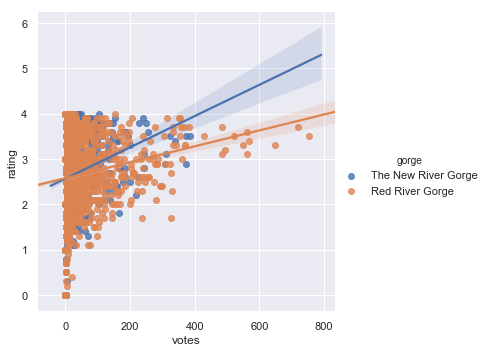

In [107]:
sns.lmplot(data=df, x='votes', y='rating', hue='gorge')

We see that there is a positive association between ratings and votes for both the New and the Red.
This could mean that people are more likely to go on Mountain Project and vote on a climb they really like.
It could also be that people are just more likely to climb (and then rate) highly-rated routes.

We also see that where there are fewer votes, the ratings are more dispersed, as we would expect,
given the variance-reducing effects of averaging.

Going forward, the main use of `votes` will be to account for the reliability of the average ratings.
The easiest way to do this is by removing from consideration all those average ratings with fewer than, say, 10 votes,
though we could also use some kind of weighting scheme.

Below we filter out all the routes that have fewer than 10 votes.
This eliminates almost half of the data!
We could choose some other threshold, perhaps trying to come up with some principled reason for a certain threshold,
but for now, let's just use the arbitrary '10 votes' threshold.
Either way, to be thorough, it would be best to do some kind of sensitivity analysis to see how much our findings rely on this choice.
But we won't do that here, since this is supposed to be just a quick analysis.

In [108]:
df_10 = df[df.votes < 10]
print(df_10.shape)
len(df_10) / len(df)

(1789, 16)


0.5487730061349694

Okay, now that we've singled out the 'reliable' ratings in some sense, let's see how the two gorges compare.

We see below, that the distributions of ratings look virtually identical across the two gorges.

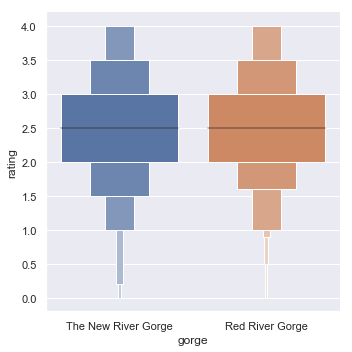

In [112]:
sns.catplot(data=df_10, x='gorge', y='rating', kind='boxen')

Now let's see how the type of route affects the rating, stratified by gorge.

The first graph shows us that the New has slightly higher rated trad routes than the Red,
while the two gorges are comparable in terms of sport route ratings.

The second graph has swapped the roles of `type` and `gorge` so that we can make within-gorge comparisons better.
It shows us that sport climbs just barely tend to be more highly rated than trad climbs at the New, whereas the gap is somewhat larger at the Red.
That's kind of interesting.

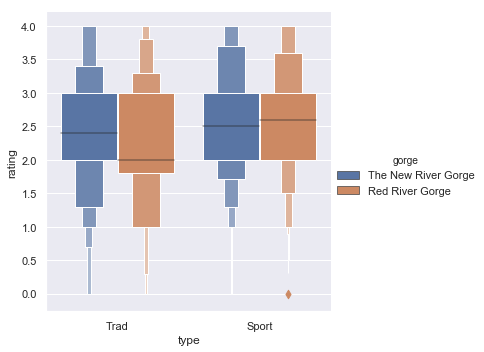

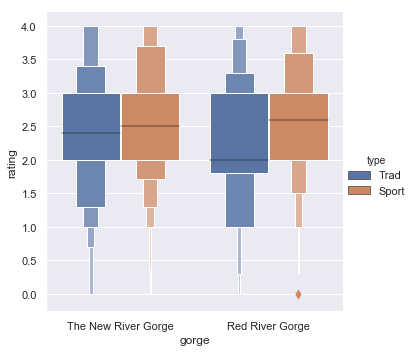

In [118]:
sns.catplot(data=df_10, x='type', y='rating', kind='boxen', hue='gorge')
sns.catplot(data=df_10, x='gorge', y='rating', kind='boxen', hue='type')

Next, let's see how the difficulty of the climb affects how much people like it.

The first collection of boxplots shows that there is, in general, an increasing trend.
People tend to rate harder climbs more highly.

The second plot stratifies by gorge.
It shows that the trend is maybe a little bit stronger at the New than at the Red.
(Incidentally, it also shows that there are not very many routes <5.5 range at the New.
At least not many that people actually climb and rate.)

I also find it amusing that in these plots
the 5.8 and 5.9 climbs have some of the longest whiskers, indicating that they have high variability in ratings.
That's consistent with my experience that 5.8s and 5.9s can be really good or really awful.

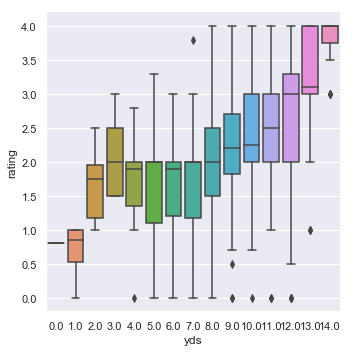

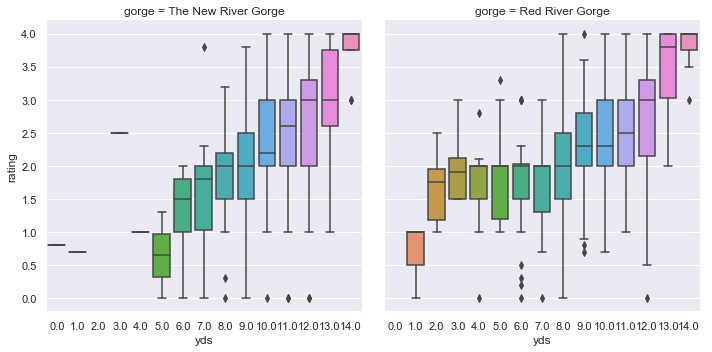

In [121]:
sns.catplot(data=df_10, x='yds', y='rating', kind='box')
sns.catplot(data=df_10, x='yds', y='rating', kind='box', col='gorge')

Finally, let's look at length.

The plot below tells us that climbers tend to like longer routes better, which has been my experience.
It also shows that the Red has more long routes than the New, since the right half of the plot is almost all orange dots.

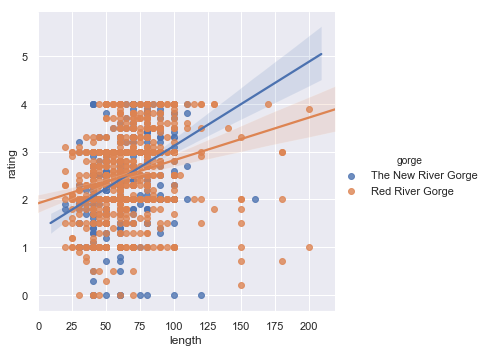

In [124]:
sns.lmplot(data=df_10, x='length', y='rating', hue='gorge')

Let's wrap up for now.

What did we learn?
It seems longer, harder routes tend to be rated more highly, at both the Red and the New.
We also learned that the Red has more routes with a lot of votes (>400), which could indicate that it is a more popular or classic climbing area.
We learned that the Red has the longest routes between it and the New.

We learned that people slightly prefer the New's trad climbing to the Red's trad climbing, but that they are equally-rated in terms of sport climbing. Also, both types of climbing are about equally rated at the New, while at the Red, sport climbing tends to be more highly rated than trad climbing.

Feel free to download the data and see what else you can learn.
There's tons of questions that I didn't ask at all.
For example, I didn't even use the other location columns besides `gorge`.
Maybe you can figure out which crags have the best climbing.
Or which gorge has more 'good' crags?
You could also go back to data cleaning and try to extract more information from the `grade` column.
Perhaps 'a' routes (no matter whether its 5.10a or 5.13a) are rated more highly than 'd' routes?
That would be interesting.